# Clustering Crypto

In [116]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [117]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [118]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [119]:
# Alternatively, use the provided csv file:
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col=0)

# Create a DataFrame
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [120]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'


In [121]:
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [122]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading'] == True]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [123]:
# Keep only cryptocurrencies with a working algorithm
for column in crypto_df.columns:
    print(f"Column {column} has {crypto_df[column].isnull().sum()} null values")

Column CoinName has 0 null values
Column Algorithm has 0 null values
Column IsTrading has 0 null values
Column ProofType has 0 null values
Column TotalCoinsMined has 459 null values
Column TotalCoinSupply has 0 null values


In [124]:
# Remove the "IsTrading" column
crypto_df_new = crypto_df.drop(columns=['IsTrading'])
crypto_df_new.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [125]:
# Remove rows with at least 1 null value
crypto_df_new = crypto_df_new.dropna()
crypto_df_new.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [126]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df_new = crypto_df_new[crypto_df_new['TotalCoinsMined'] != 0]
crypto_df_new.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [127]:
# Drop rows where there are 'N/A' text values
crypto_df_new = crypto_df_new[crypto_df_new !='N/A']
crypto_df_new.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [128]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df and Index
coins_name = pd.DataFrame(crypto_df_new['CoinName'])
coins_name.head()


,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [129]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df_new = crypto_df_new.drop(columns=['CoinName'])
crypto_df_new.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [130]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df_new[['Algorithm', 'ProofType']])
X.head()


,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,Algorithm_Cloverhash,Algorithm_Counterparty,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(X)
print(crypto_scaled[0:5])

[[-0.0433555  -0.0433555  -0.0433555  -0.06137164 -0.07523548 -0.0433555
  -0.06137164 -0.06137164 -0.0433555  -0.0433555  -0.19226279 -0.06137164
  -0.09731237 -0.0433555  -0.11536024 -0.07523548 -0.0433555  -0.0433555
  -0.15176505 -0.0433555  -0.13105561 -0.0433555  -0.0433555  -0.08695652
  -0.0433555  -0.0433555  -0.0433555  -0.0433555  -0.06137164 -0.0433555
  -0.08695652 -0.08695652 -0.08695652 -0.0433555  -0.13105561 -0.13827675
  -0.13827675 -0.0433555  -0.06137164 -0.0433555  -0.07523548 -0.1815096
  -0.0433555  -0.0433555  -0.0433555  -0.07523548 -0.15811388 -0.3145935
  -0.0433555  -0.08695652 -0.07523548 -0.06137164 -0.0433555   1.38873015
  -0.0433555  -0.0433555  -0.06137164 -0.0433555  -0.0433555  -0.0433555
  -0.0433555  -0.0433555  -0.0433555  -0.0433555  -0.0433555  -0.39836623
  -0.0433555  -0.1815096  -0.0433555  -0.08695652 -0.08695652 -0.10670145
  -0.0433555  -0.0433555  -0.13105561 -0.0433555  -0.0433555  -0.0433555
  -0.0433555  -0.07523548 -0.4386271  -0.0433

### Reducing Dimensions Using PCA

In [132]:
# Initialize PCA model
pca = PCA(n_components=3)
print(crypto_scaled[0:20])

# Use PCA to reduce dimensions to 3 principal components
crypto_pca = pca.fit_transform(crypto_scaled)


[[-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]
 [-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]
 [-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]
 ...
 [-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]
 [-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]
 [-0.0433555 -0.0433555 -0.0433555 ... -0.0433555 -0.0433555 -0.0433555]]


In [133]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data=crypto_pca,
    columns=["PC 1", "PC 2", "PC 3"],
    index=crypto_df_new.index

)
pcs_df.head(10)


,PC 1,PC 2,PC 3
42,1.014099,-0.708930,-0.002485
404,1.014099,-0.708930,-0.002485
1337,1.770482,-0.781781,-0.000258
BTC,-1.249896,0.245768,0.013076
ETH,-1.963110,0.452870,-0.013238
LTC,-1.089237,-0.012295,0.001541
DASH,1.247148,-0.649922,0.002069
XMR,-2.184610,0.464764,-0.011659
ETC,-1.963110,0.452870,-0.013238
ZEC,-1.860098,0.503701,-0.000357


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [134]:
# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=5`

In [135]:
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.DataFrame({
    "Algorithm": crypto_df_new.Algorithm,
    "ProofType": crypto_df_new.ProofType,
    "TotalCoinsMined": crypto_df_new.TotalCoinsMined,
    "TotalCoinSupply": crypto_df_new.TotalCoinSupply,
    "PC 1": pcs_df['PC 1'],
    "PC 2": pcs_df['PC 2'],
    "PC 3": pcs_df['PC 3'],
    "CoinName": coins_name.CoinName,
    "Class": model.labels_,
    },index=crypto_df_new.index
)
clustered_df.head(10)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,1.014099,-0.708930,-0.002485,42 Coin,1
404,Scrypt,PoW/PoS,1.055185e+09,532000000,1.014099,-0.708930,-0.002485,404Coin,1
1337,X13,PoW/PoS,2.927942e+10,314159265359,1.770482,-0.781781,-0.000258,EliteCoin,1
BTC,SHA-256,PoW,1.792718e+07,21000000,-1.249896,0.245768,0.013076,Bitcoin,0
ETH,Ethash,PoW,1.076842e+08,0,-1.963110,0.452870,-0.013238,Ethereum,0
LTC,Scrypt,PoW,6.303924e+07,84000000,-1.089237,-0.012295,0.001541,Litecoin,0
DASH,X11,PoW/PoS,9.031294e+06,22000000,1.247148,-0.649922,0.002069,Dash,1
XMR,CryptoNight-V7,PoW,1.720114e+07,0,-2.184610,0.464764,-0.011659,Monero,0
ETC,Ethash,PoW,1.133597e+08,210000000,-1.963110,0.452870,-0.013238,Ethereum Classic,0
ZEC,Equihash,PoW,7.383056e+06,21000000,-1.860098,0.503701,-0.000357,ZCash,0


### Visualizing Results

#### 3D-Scatter with Clusters

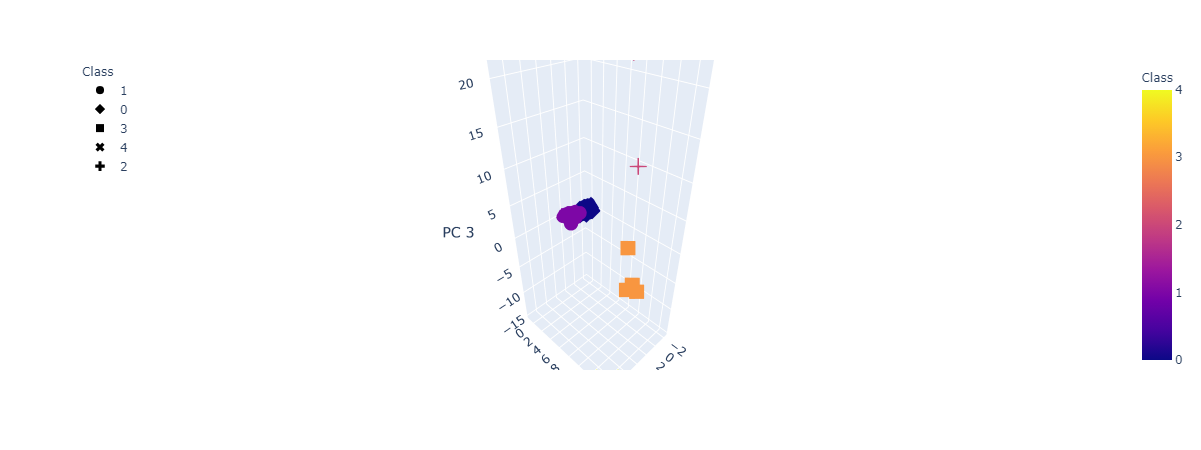

In [136]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    color="Class",
    symbol="Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


#### Table of Tradable Cryptocurrencies

In [137]:
# Table with tradable cryptos
columns = ["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"]
clustered_df.hvplot.table(columns)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [138]:
# Print the total number of tradable cryptocurrencies
clustered_df.shape[0]

533

#### Scatter Plot with Tradable Cryptocurrencies

In [139]:
# Scale data to create the scatter plot
scaler = StandardScaler()
clustered_df[["TotalCoinsMined", "TotalCoinSupply"]] = scaler.fit_transform(clustered_df[["TotalCoinsMined", "TotalCoinSupply"]])
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
42,Scrypt,PoW/PoS,-0.116748,-0.152865,1.014099,-0.708930,-0.002485,42 Coin,1
404,Scrypt,PoW/PoS,-0.093589,-0.144996,1.014099,-0.708930,-0.002485,404Coin,1
1337,X13,PoW/PoS,0.525872,4.493764,1.770482,-0.781781,-0.000258,EliteCoin,1
BTC,SHA-256,PoW,-0.116354,-0.152554,-1.249896,0.245768,0.013076,Bitcoin,0
ETH,Ethash,PoW,-0.114384,-0.152865,-1.963110,0.452870,-0.013238,Ethereum,0


In [140]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["CoinName"],
    by="Class"
)

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)